# Universal noise

This notebook computes a universal noise pattern, which can be added to any image 
and missleads the open pose network 

In [2]:
%load_ext autoreload
%autoreload 2
# imports
import datetime
import logging
import os
import pathlib
import sys

import cv2
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from tqdm import tqdm

from loss_functions import multi_stage_loss
from plot_utils import gen_plot_universal_noise, plot_pose
from tf_pose import common
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path
from utils import load_batch
import glob 

sys.path.insert(0, os.path.abspath('..'))
sys.path.insert(0, os.path.abspath('../..'))


os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
logging.getLogger("tensorflow").setLevel(logging.CRITICAL)
logging.getLogger('TfPoseEstimatorRun').setLevel(logging.ERROR)
logging.getLogger('DeepExplain').setLevel(logging.ERROR)
logging.getLogger('TfPoseEstimator').setLevel(logging.ERROR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
image_path_targets = []
for file in glob.glob("../data/generated/*.xml"):
    filename, file_extension = os.path.splitext(file)
    image_path_targets.append(filename)
    
image_path_targets.reverse()
print(f'Found {len(image_path_targets)} images')

Found 49 images


In [6]:
# params 432, 368
w, h = 432, 368
TEST_CNT = 16
image_path_targets = image_path_targets[:TEST_CNT]

image_targets = [common.read_imgfile(f'{image_path_target}.jpg', w, h) for image_path_target in image_path_targets]
image_masks = [common.read_imgfile(f'{image_path_target}_mask.png', w, h, cv2.IMREAD_GRAYSCALE) > 0 for image_path_target in image_path_targets]

model = 'cmu'
log_dir = '../logs/'

resize_out_ratio = 4.0
summary_writer = tf.summary.FileWriter(
    log_dir + "uniadv_rendering/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [7]:
image_target = image_targets[1]
estimator = TfPoseEstimator(get_graph_path(model), target_size=(w, h), trt_bool=False)
upsample_size = [int(estimator.target_size[1] / 8 * resize_out_ratio),
                 int(estimator.target_size[0] / 8 * resize_out_ratio)]
# get all outputs as np matrix
target_np, target_np_heat, target_np_paf, target_np_peaks = estimator.persistent_sess.run(
    [estimator.tensor_output, estimator.tensor_heatMat_up,
        estimator.tensor_pafMat_up, estimator.tensor_peaks],
    feed_dict={
        estimator.tensor_image: [image_target],
        estimator.upsample_size: upsample_size
    }
)

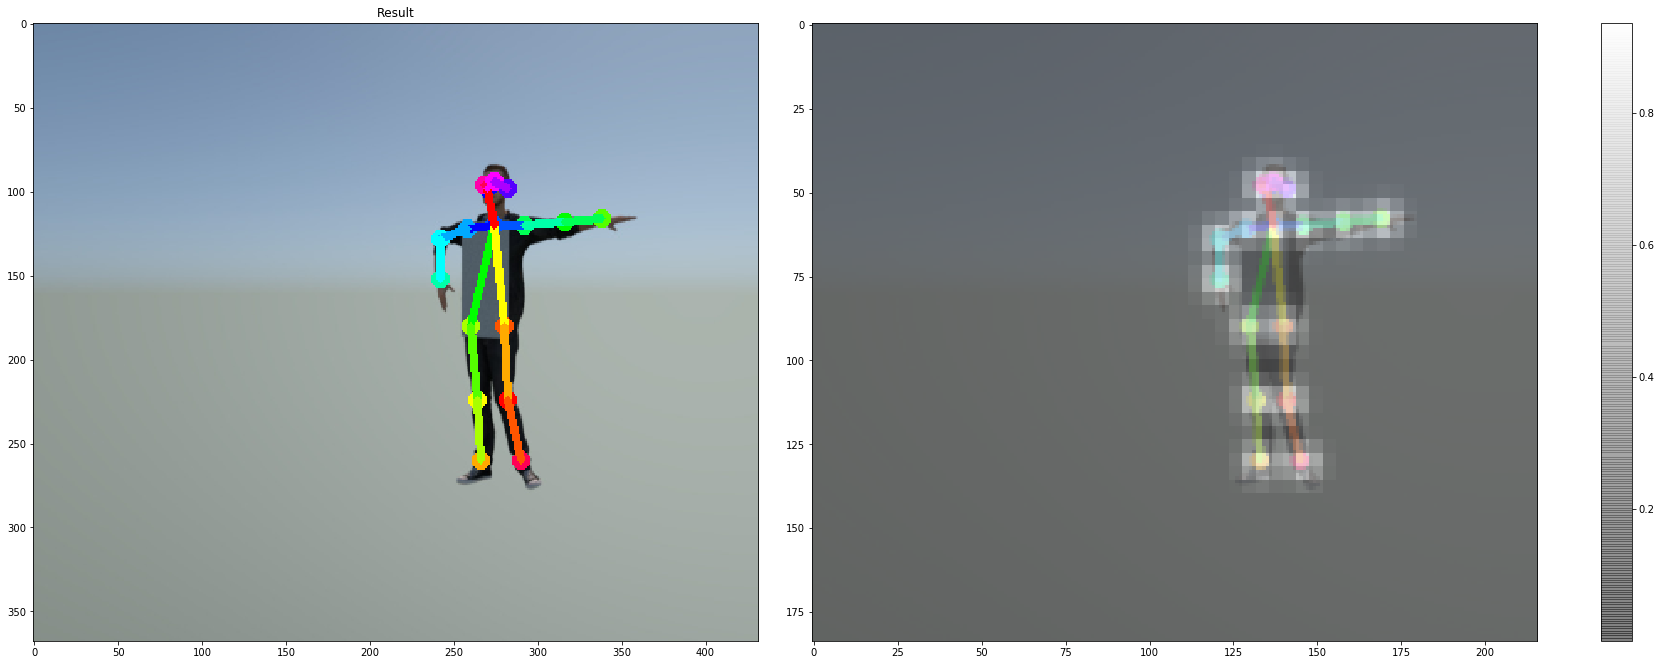

In [8]:
human_target = estimator.inference(
    image_target, resize_to_default=True, upsample_size=resize_out_ratio)
plot_pose(image_target, human_target, estimator.heatMat)

(368, 432)


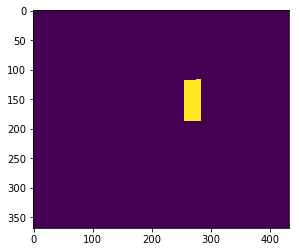

In [9]:
plt.imshow(image_masks[1])
print(image_masks[1].shape)

In [10]:
def get_universal_noise(estimator, image_target, universal_noise_filename, mask):
    EPS = 5000
    STEPS = 1000
    STAGE_INDEX = 6  # range from 2 to 6
    BATCH_SIZE = 16
    
    upsample_size = [int(estimator.target_size[1] / 8 * resize_out_ratio),
                 int(estimator.target_size[0] / 8 * resize_out_ratio)]
    
    # get all outputs as np matrix
    target_np_heat = np.zeros((1, 46, 54, 19))
    target_np_paf = np.zeros((1, 46, 54, 38))


    # where does the current batch start
    training_stats = {
        'image_index': 0,
        'universal_noise': np.zeros(image_target.shape),
        'file_name': f'../snapshots/{universal_noise_filename}.npy'
    }
    
    target_heat = tf.compat.v1.placeholder(
        tf.float32, shape=(None, None, None, 19))
    target_paf = tf.compat.v1.placeholder(
        tf.float32, shape=(None, None, None, 38))
    grad_func, loss_func = multi_stage_loss(
        estimator, target_heat, target_paf, STAGE_INDEX)
    

    ### ================= TRAINING ================= ###

    for i in tqdm(range(STEPS)):
        # add noise to target
        image_target_with_noise = image_target + training_stats['universal_noise']
       
        gradient, gn_summ = estimator.persistent_sess.run(
            [grad_func, loss_func],
            feed_dict={
                target_heat: target_np_heat,
                target_paf: target_np_paf,
                estimator.tensor_image: [image_target_with_noise],
                estimator.upsample_size: upsample_size
            }
        )
        summary_writer.add_summary(gn_summ, training_stats['image_index'])

        if i % 25 == 0:
            # save universal noise
            np.save(training_stats['file_name'], training_stats['universal_noise'])

        ### ================= UPDATE STEP ================= ###
        #adv_image = adv_image - EPS * np.sign(gradient[0])
        scaled_gradient = mask[..., None] * (EPS * gradient[0])
        training_stats['universal_noise'] = training_stats['universal_noise'] - scaled_gradient
        training_stats['universal_noise'] = np.clip(training_stats['universal_noise'], 0, 255)

        training_stats['image_index'] += 1


    summary_writer.flush()
    return training_stats['universal_noise']

In [11]:
universal_noises = []
universal_noise_filenames = [f'{image_path_target}_uni_noise' for image_path_target in image_path_targets]
for (i, image_target) in enumerate(image_targets):
    universal_noises.append(
        get_universal_noise(estimator, image_target, universal_noise_filenames[i], image_masks[i]))

100%|██████████| 1000/1000 [02:45<00:00,  6.03it/s]


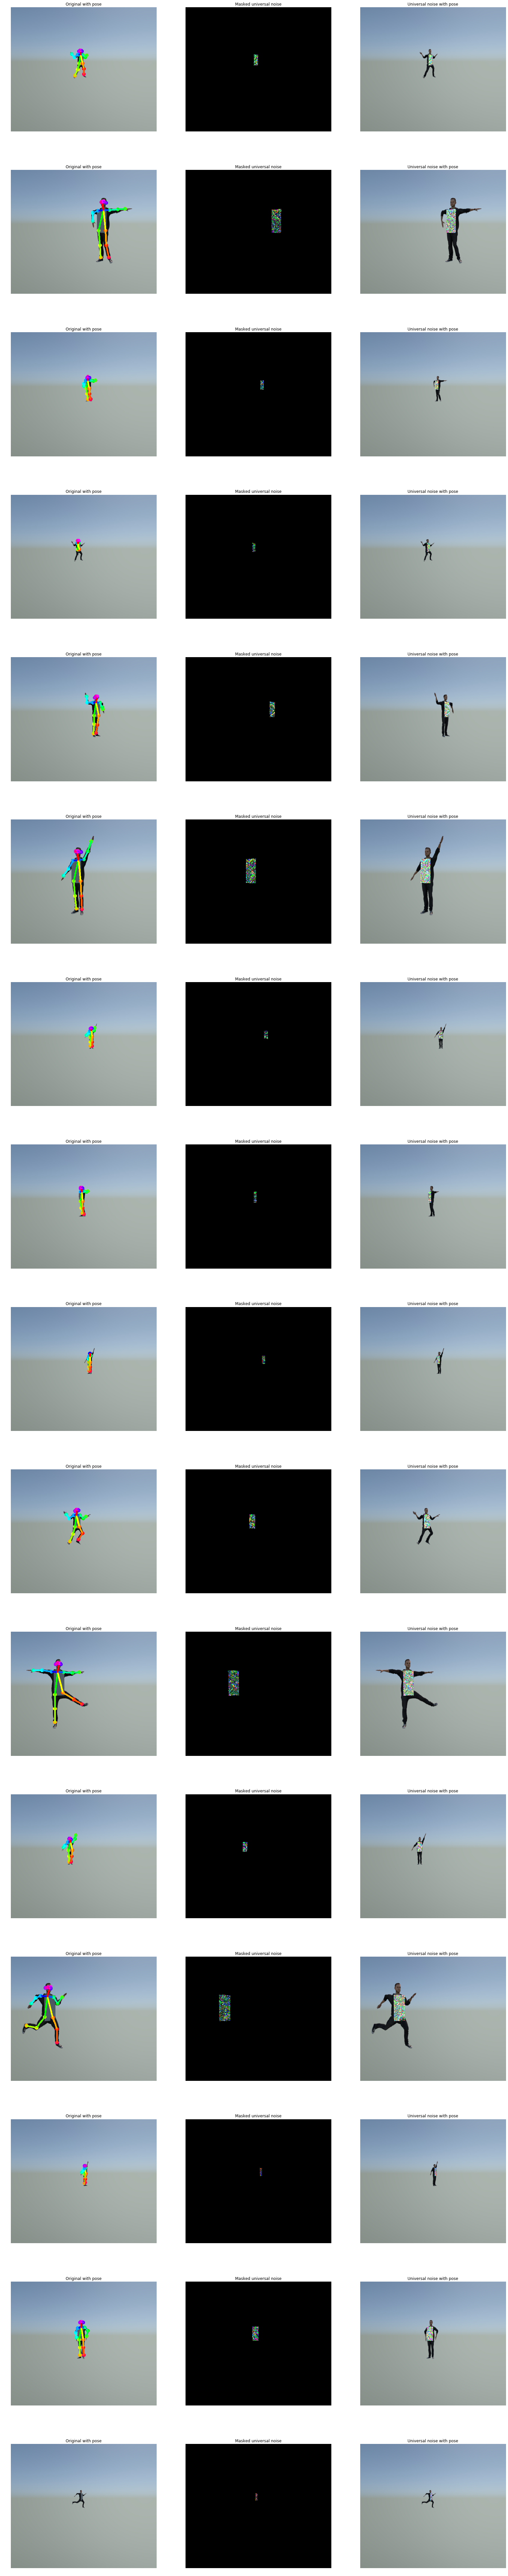

In [12]:
# Plot attributions
%matplotlib inline
n_cols = 3
n_rows = len(image_targets)
fig_scale = 3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(
    3*n_cols*fig_scale, 3*n_rows*fig_scale))

plot_cnt = 0

for i, xi in enumerate(image_targets):
    detections = estimator.inference(xi, resize_to_default=True, upsample_size=resize_out_ratio)
    detections_result = TfPoseEstimator.draw_humans(xi, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Original with pose')
    ax.axis('off')
    plot_cnt += 1
    
    universal_noise = universal_noises[i]
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(universal_noise / 255.0)
    ax.set_title(f'Masked universal noise')
    ax.axis('off')
    plot_cnt += 1
    
    xi_with_noise = np.clip(xi + universal_noise, 0, 255).astype(np.float32) / 255.0
    detections = estimator.inference(xi_with_noise, resize_to_default=True, upsample_size=resize_out_ratio)
    detections_result = TfPoseEstimator.draw_humans(xi_with_noise, detections, imgcopy=True)
    
    ax = axes.flatten()[plot_cnt]
    ax.imshow(cv2.cvtColor(detections_result, cv2.COLOR_BGR2RGB))
    ax.set_title(f'Universal noise with pose')
    ax.axis('off')
    plot_cnt += 1
    
    
    
    